# Part 1

In [1]:
import os
import numpy as np
import soundfile as sf
import scipy.signal
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq

In [2]:
# --- все функции ---
def normalize(x):
    return x / (np.max(np.abs(x)) + 1e-9)

def remove_dc(x):
    return x - np.mean(x)

def align_signals(ref, target):
    """Выровнять сигнал target относительно ref по максимуму корреляции."""
    corr = scipy.signal.correlate(target, ref, mode='full')
    lag = np.argmax(np.abs(corr)) - len(ref) + 1
    if lag > 0:
        target_aligned = target[lag:]
        ref_aligned = ref[:len(target_aligned)]
    else:
        ref_aligned = ref[-lag:]
        target_aligned = target[:len(ref_aligned)]
    minlen = min(len(ref_aligned), len(target_aligned))
    return ref_aligned[:minlen], target_aligned[:minlen]

def split_into_bands(fft_data, sample_rate, num_bands=16):
    """Разбить амплитуды FFT на логарифмические полосы (например, 16)."""
    N = len(fft_data)
    freqs = fftfreq(N, 1/sample_rate)
    positive = freqs[:N//2]
    amp = np.abs(fft_data[:N//2])
    band_edges = np.logspace(np.log10(20), np.log10(sample_rate/2), num_bands+1)
    bands = np.zeros(num_bands)
    for i in range(num_bands):
        fmin, fmax = band_edges[i], band_edges[i+1]
        mask = (positive >= fmin) & (positive < fmax)
        if np.any(mask):
            bands[i] = np.mean(amp[mask])
        else:
            bands[i] = 0
    return bands, band_edges

def apply_gains_to_fft(fft_data, sample_rate, gains, band_edges):
    """Мультиплицировать амплитуды FFT в полосах на коэффициенты коррекции."""
    N = len(fft_data)
    freqs = fftfreq(N, 1/sample_rate)
    out_fft = fft_data.copy()
    for i, g in enumerate(gains):
        fmin, fmax = band_edges[i], band_edges[i+1]
        mask_pos = (np.abs(freqs) >= fmin) & (np.abs(freqs) < fmax)
        out_fft[mask_pos] *= g
    return out_fft

def deconv(recorded, original, epsilon=1e-7):
    """Деконволюция с защитой по eps (remove small denominator)."""
    N = len(recorded)
    orig_zpad = np.zeros(N)
    orig_zpad[:len(original)] = original
    Rec = fft(recorded)
    Orig = fft(orig_zpad)
    H = Rec / (Orig + epsilon)
    ir = ifft(H).real
    return ir

def highpass_ir(ir, sr, lowcut=120.0):
    """Высокочастотный фильтр для отклика IR, чтобы убрать гул (опционально)."""
    sos = scipy.signal.butter(1, lowcut, btype='highpass', fs=sr, output='sos')
    return scipy.signal.sosfilt(sos, ir)


In [3]:
# === 1. Загрузка файлов, нормализация ===
swip_orig, sr_swip = sf.read('sounds/swip_orig.wav', dtype='float32')
swip_rec, sr_swip2 = sf.read('sounds/swip_blanket.wav', dtype='float32')
noise_white, sr_white = sf.read('sounds/noise_white.wav', dtype='float32')
noise_white_recorded, sr_white = sf.read('sounds/corrected_noise_kitchen.wav', dtype='float32')

swip_orig, swip_rec = normalize(remove_dc(swip_orig)), normalize(remove_dc(swip_rec))
noise_white = normalize(remove_dc(noise_white))
noise_white_recorded = normalize(remove_dc(noise_white_recorded))


In [4]:
# === 2. Привести всё к одной длине ===
if isinstance(swip_orig, np.ndarray) and swip_orig.ndim > 1:
    swip_orig = swip_orig[:,0]
if isinstance(swip_rec, np.ndarray) and swip_rec.ndim > 1:
    swip_rec = swip_rec[:,0]
minlen_sweep = min(len(swip_orig), len(swip_rec))
swip_orig, swip_rec = swip_orig[:minlen_sweep], swip_rec[:minlen_sweep]

minlen_sweep = min(len(swip_orig), len(swip_rec))
swip_orig, swip_rec = swip_orig[:minlen_sweep], swip_rec[:minlen_sweep]

In [5]:
# === 3. FFT и разбиение на полосы для свипа ===
num_bands = 16
fft_sweep_orig = fft(swip_orig)
fft_sweep_rec = fft(swip_rec)
amps_orig, band_edges = split_into_bands(fft_sweep_orig, sr_swip, num_bands)
amps_rec, _ = split_into_bands(fft_sweep_rec, sr_swip, num_bands)
eq_gains = np.array([a_rec / (a_orig + 1e-9) for a_rec, a_orig in zip(amps_rec, amps_orig)])

In [6]:
# === 4. FFT белого шума и коррекция по гейнам (АЧХ) ===
if isinstance(noise_white, np.ndarray) and noise_white.ndim > 1:
    noise_white = noise_white[:,0]
print(type(swip_orig), swip_orig.shape)
print(type(swip_rec), swip_rec.shape)
minlen_white = min(len(noise_white), len(swip_orig))
noise_white_use = noise_white[:minlen_white]
fft_white = fft(noise_white_use)
inv_eq_gains = 1./(eq_gains + 1e-9)
fft_white_corrected = apply_gains_to_fft(fft_white, sr_white, inv_eq_gains, band_edges)
noise_white_corrected = ifft(fft_white_corrected).real
noise_white_corrected = normalize(noise_white_corrected)

# --- Сохраняем корректированный белый шум для воспроизведения ---
sf.write('sounds/corrected_white_noise.wav', noise_white_corrected.astype('float32'), sr_white)

<class 'numpy.ndarray'> (960960,)
<class 'numpy.ndarray'> (960960,)


In [7]:
# === 5. Запишите скорректированный шум в комнате (ОТДЕЛЬНО!), затем загрузите его ===
noise_white_room, sr_noise_room = sf.read('sounds/corrected_noise_kitchen.wav', dtype='float32')
noise_white_room = normalize(remove_dc(noise_white_room))
noise_white_corrected = noise_white_corrected[:len(noise_white_room)]

In [8]:
# === 6. Выравнивание перед деконволюцией ===
nw_corr_aligned, nw_room_aligned = align_signals(noise_white_corrected, noise_white_room)

In [9]:
# === 7. Деконволюция: получаем IR ===
ir = deconv(nw_room_aligned, nw_corr_aligned)
# Центрирование по максимуму, обрезка основной части
peak = np.argmax(np.abs(ir))
win_size = int(0.08 * sr_white)   # 80 мс окно (можно варьировать)
start = max(peak, 0)
end = min(start+win_size, len(ir))
ir_win = ir[start:end]
ir_win = ir_win * np.hanning(len(ir_win))
ir_win = highpass_ir(ir_win, sr_white, lowcut=100.0)
ir_win = normalize(ir_win)
sf.write('sounds/ir_final.wav', ir_win.astype('float32'), sr_white)

In [10]:
# === 8. Применение IR к чистому сигналу ===
clean_test, sr_test = sf.read('sounds/clear_voice.wav', dtype='float32')
clean_test = normalize(remove_dc(clean_test))
test_convolved = scipy.signal.fftconvolve(clean_test, ir_win, mode='full')
test_convolved = normalize(test_convolved[:len(clean_test)])
sf.write('sounds/voice_convolved.wav', test_convolved.astype('float32'), sr_white)

In [11]:
# === 9. Сравнение с реальной записью ===
test_recorded, sr_rec = sf.read('sounds/voice_kitchen.wav', dtype='float32')
test_recorded = normalize(remove_dc(test_recorded[:len(test_convolved)]))
sf.write('sounds/test_recorded_trimmed.wav', test_recorded.astype('float32'), sr_white)

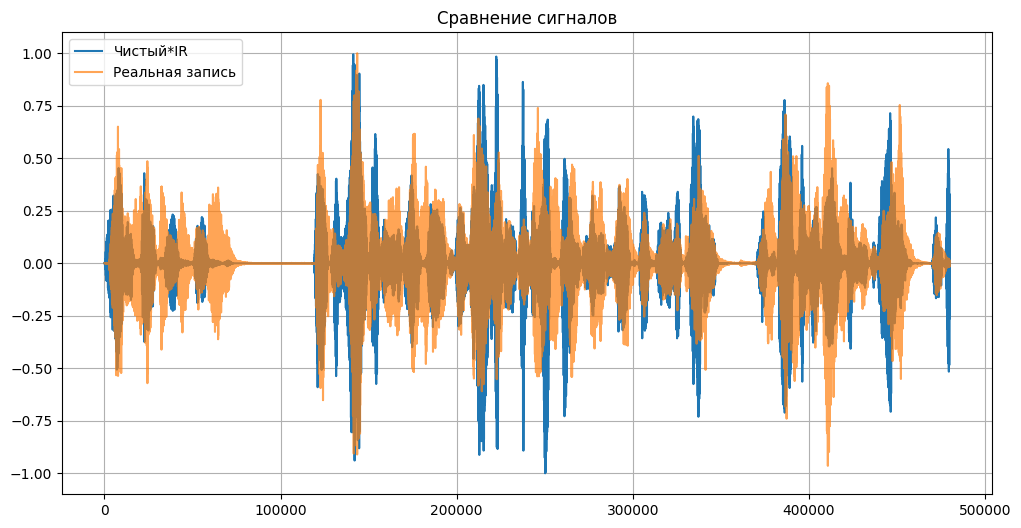

In [12]:
# === 10. ВИЗУАЛИЗАЦИЯ ===
plt.figure(figsize=(12,6))
plt.plot(test_convolved, label="Чистый*IR")
plt.plot(test_recorded, alpha=0.7, label="Реальная запись")
plt.legend()
plt.title("Сравнение сигналов")
plt.grid()
plt.show()

Полученный после свертки с импульсным откликом голос на мой слух звучит хуже - стало очень глухо, звучание как из бочки. Связываю это с этим с недостаточно качественным выравниванием дорожек во времени.